### Samsung electronics

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr 

start_date = '2000-01-01'
end_date = '2024-03-11'

data = pdr.DataReader('005930', 'naver', start = start_date, end = end_date)

In [21]:
data = data.astype(int)

In [22]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,6000,6110,5660,6110,1483967
2000-01-05,5800,6060,5520,5580,1493604
2000-01-06,5750,5780,5580,5620,1087810
2000-01-07,5560,5670,5360,5540,806195
2000-01-10,5600,5770,5580,5770,937615
...,...,...,...,...,...
2024-03-05,74600,74800,73700,73700,19505125
2024-03-06,73200,73500,72700,72900,21547905
2024-03-07,73100,73300,72200,72200,14516963


In [23]:
import pykrx as px

data_fund = px.stock.get_market_fundamental(start_date, end_date, '005930')

In [24]:
data_fund

,BPS,PER,PBR,EPS,DIV,DPS
날짜,,,,,,
2000-01-04,0,152.37,0.00,2005,0.20,600
2000-01-05,0,139.15,0.00,2005,0.22,600
2000-01-06,0,140.15,0.00,2005,0.21,600
2000-01-07,0,138.15,0.00,2005,0.22,600
2000-01-10,0,143.89,0.00,2005,0.21,600
...,...,...,...,...,...,...
2024-03-05,57822,9.15,1.27,8057,1.96,1444
2024-03-06,57822,9.05,1.26,8057,1.98,1444
2024-03-07,57822,8.96,1.25,8057,2.00,1444


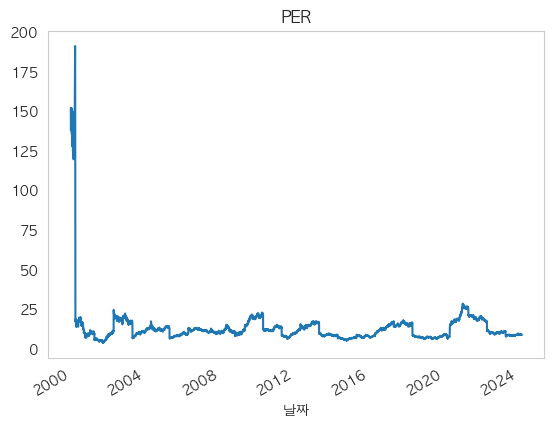

In [25]:
data_fund['PER'].plot(
    grid = False,
    title = 'PER'
)
plt.show()

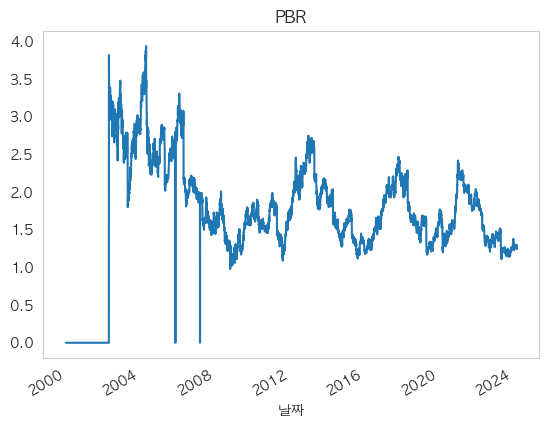

In [26]:
data_fund['PBR'].plot(
    grid = False,
    title = 'PBR'
)
plt.show()

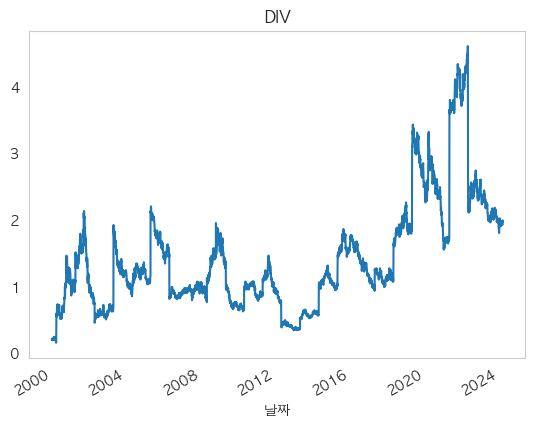

In [27]:
data_fund['DIV'].plot(
    grid = False,
    title = 'DIV'
)
plt.show()

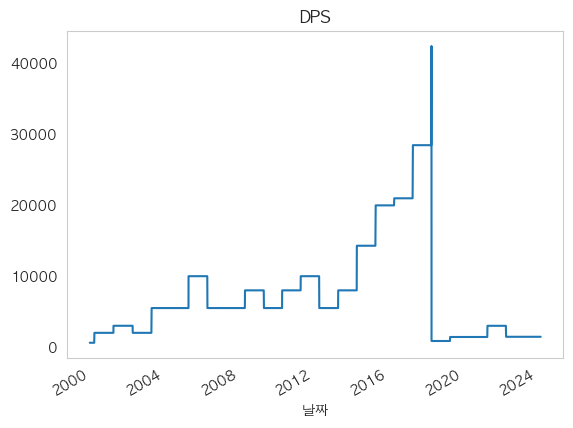

In [28]:
data_fund['DPS'].plot(
    grid = False,
    title = 'DPS'
)
plt.show()

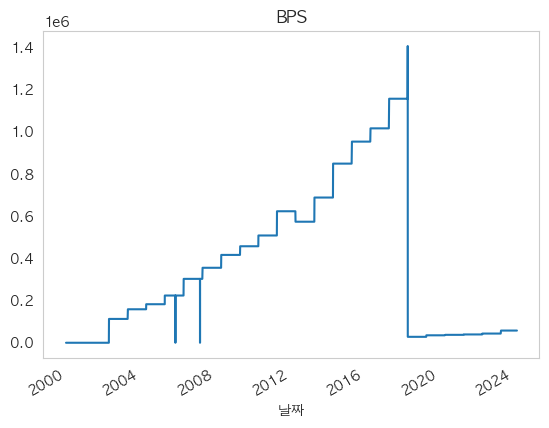

In [29]:
data_fund['BPS'].plot(
    grid = False,
    title = 'BPS'
)
plt.show()